### Business Cycle Strategy [ 策略更新時間：2025-05-17 ]

> 景氣信號燈是用以衡量台灣景氣是處於擴張期還是衰退期的綜合指標，因此我使用景氣信號燈來進行 0050 和美國短天期國債 ETF。

> 景氣信號燈處於上升期 ---> 買進 0050 賣出 美債ETF

> 景氣信號燈處於下降期 ---> 買進 美債ETF 賣出 0050


In [9]:
import Backtest_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import matplotlib.ticker as ticker
import statsmodels.api as sm
import matplotlib.ticker as mtick
from Backtest_model import logic_para

In [7]:
Row_data = pd.read_csv(f'clean_backtest_data.csv')
data_use = Row_data.copy()
data_use['mdate'] = pd.to_datetime(data_use['mdate'])
data_use = data_use.rename(columns={
    'mdate': 'Date',
    'ROI': 'Ret',
    'coid': 'Symbol',
    'Close': 'ori_Close'
})

data_use['Close'] = data_use['ori_Close'] * data_use['Adjust_Factor']
data_use['Symbol'] = data_use['Symbol'].astype(str)
data_use = data_use.sort_values('Date')

/var/folders/st/lxg2kchn65x5y9ldzc2d4qgh0000gn/T/ipykernel_14636/314268868.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  Row_data = pd.read_csv(f'clean_backtest_data.csv')


### 蒐集景氣信號燈分數、0050、短天期美債ETF 的價格資料_____並畫出圖表


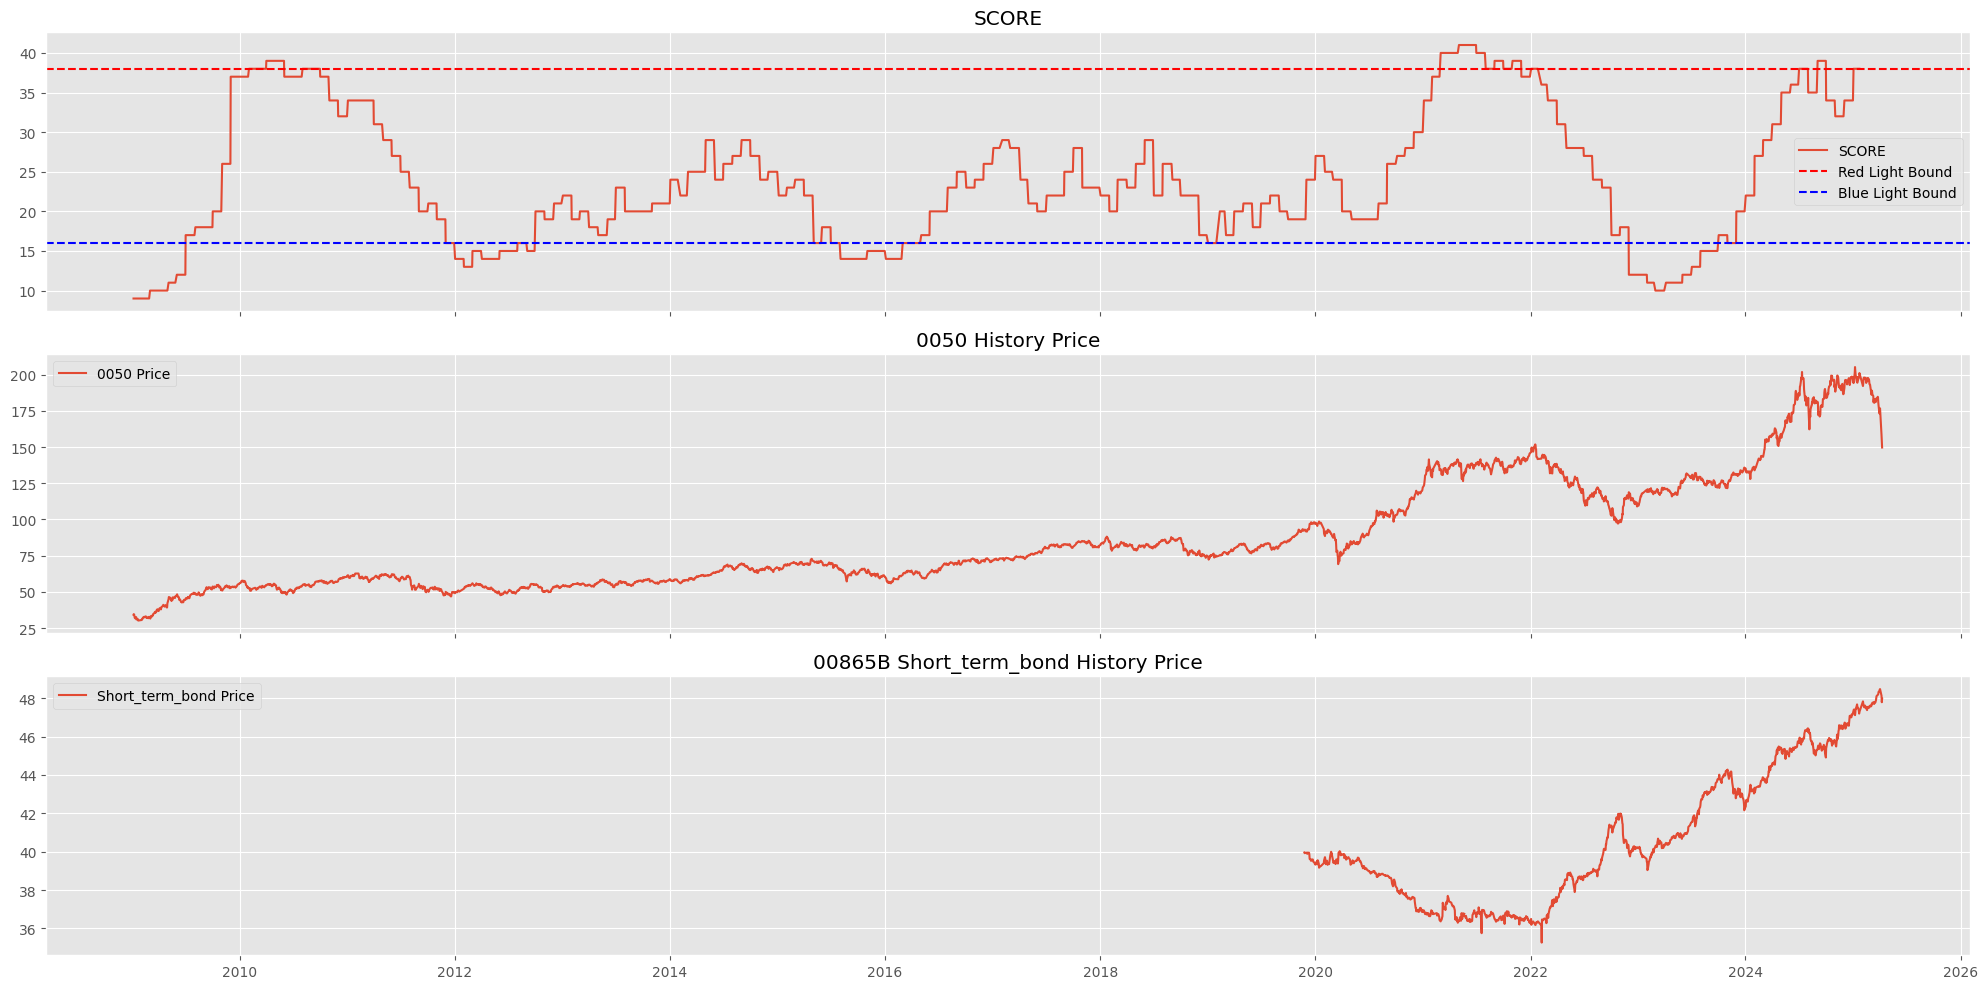

In [8]:
df = pd.read_csv('business_score_data.csv')
df['mdate'] = pd.to_datetime(df['mdate'])
df['mdate'] = df['mdate'].dt.strftime('%Y-%m-%d')
df['mdate'] = pd.to_datetime(df['mdate'])


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)
plt.style.use('ggplot')
axes[1].plot(df['mdate'], df['avgclsd'], label = '0050 Price')
axes[1].set_title(f'0050 History Price')
axes[1].legend()

axes[0].plot(df['mdate'], df['val_shifted'], label = 'SCORE')
axes[0].axhline(y = 38, label = 'Red Light Bound', color = 'red', linestyle = '--')
axes[0].axhline(y= 16, label = 'Blue Light Bound', color = 'blue', linestyle = '--')
axes[0].set_title(f'SCORE')
axes[0].legend()

axes[2].plot(df['mdate'], df['avgclsd_bond'], label = 'Short_term_bond Price')
axes[2].set_title(f'00865B Short_term_bond History Price')
axes[2].legend()

plt.tight_layout()
plt.show()

In [14]:
para = logic_para()
para.score = None
para.last_score = None
para.state = False
para.a = 0

# 策略邏輯
def logic(idx, date, portfolio, performance, market, factor_data, para):

    today_data = factor_data[factor_data['mdate'].shift(1) == pd.to_datetime(date)]
    para.last_score = para.score  

    if not today_data.empty:
        para.score = today_data['val_shifted'].iloc[-1]
    else:
        # 若無資料，就沿用舊的 score
        para.score = para.last_score

    if para.score <= 16 and para.state == False:
        
        Backtest_model.order(portfolio=portfolio, symbol='00865B', target=0.0, Market=market)
        Backtest_model.order(portfolio=portfolio, symbol='0050', target=1.0, Market=market)
        #order(portfolio=portfolio, symbol='00631L', target=1.0, Market=market)
        
        print(f'{date} 進入股市')
        para.state = True

    if para.score >= 38 and para.state == True:
        #order(portfolio=portfolio, symbol='00631L', target=0.0, Market=market)
        Backtest_model.order(portfolio=portfolio, symbol='0050', target=0.0, Market=market)
        Backtest_model.order(portfolio=portfolio, symbol='00865B', target=1.0, Market=market)
        print(f'{date} 離開股市')
        para.state = False

    if para.score > 16 and para.score < 38 and para.a == 0:
        para.a = 1
        print('進入景氣循環')
        if para.state == False:
            print(date)
            Backtest_model.order(portfolio=portfolio, symbol='0050', target=1.0, Market=market)
            #order(portfolio=portfolio, symbol='00631L', target=1.0, Market=market)
            para.state = True

result = Backtest_model.run_backtest(data = data_use,
                       strategy_function = logic, 
                       start_date = '2020-01-01', 
                       end_date = '2025-01-01', Benchmark_code = 'IR0001',
                       factor_data = df, 
                       initial_cash = 1_000_000,
                       logic_para=para)


# 呼叫函數 compute_stat() 計算回測績效數據
result.compute_stat()

-------------------------------------------------- Strategy Logic Start --------------------------------------------------
進入景氣循環
2020-01-02
2021-02-26 離開股市
2022-11-30 進入股市
2024-06-28 離開股市
-------------------------------------------------- Strategy Logic End --------------------------------------------------


,指標,數值
0,累積報酬率,1.8454
1,年化報酬率,0.2420
2,年化波動度,0.1517
3,夏普比率,1.5948
4,最大回撤,-0.2822
5,Calmar比率,0.8576
6,Alpha (年化),0.1404
7,Beta,0.4725
8,Benchmark 累積報酬率,1.2557
9,Benchmark 年化報酬率,0.1836


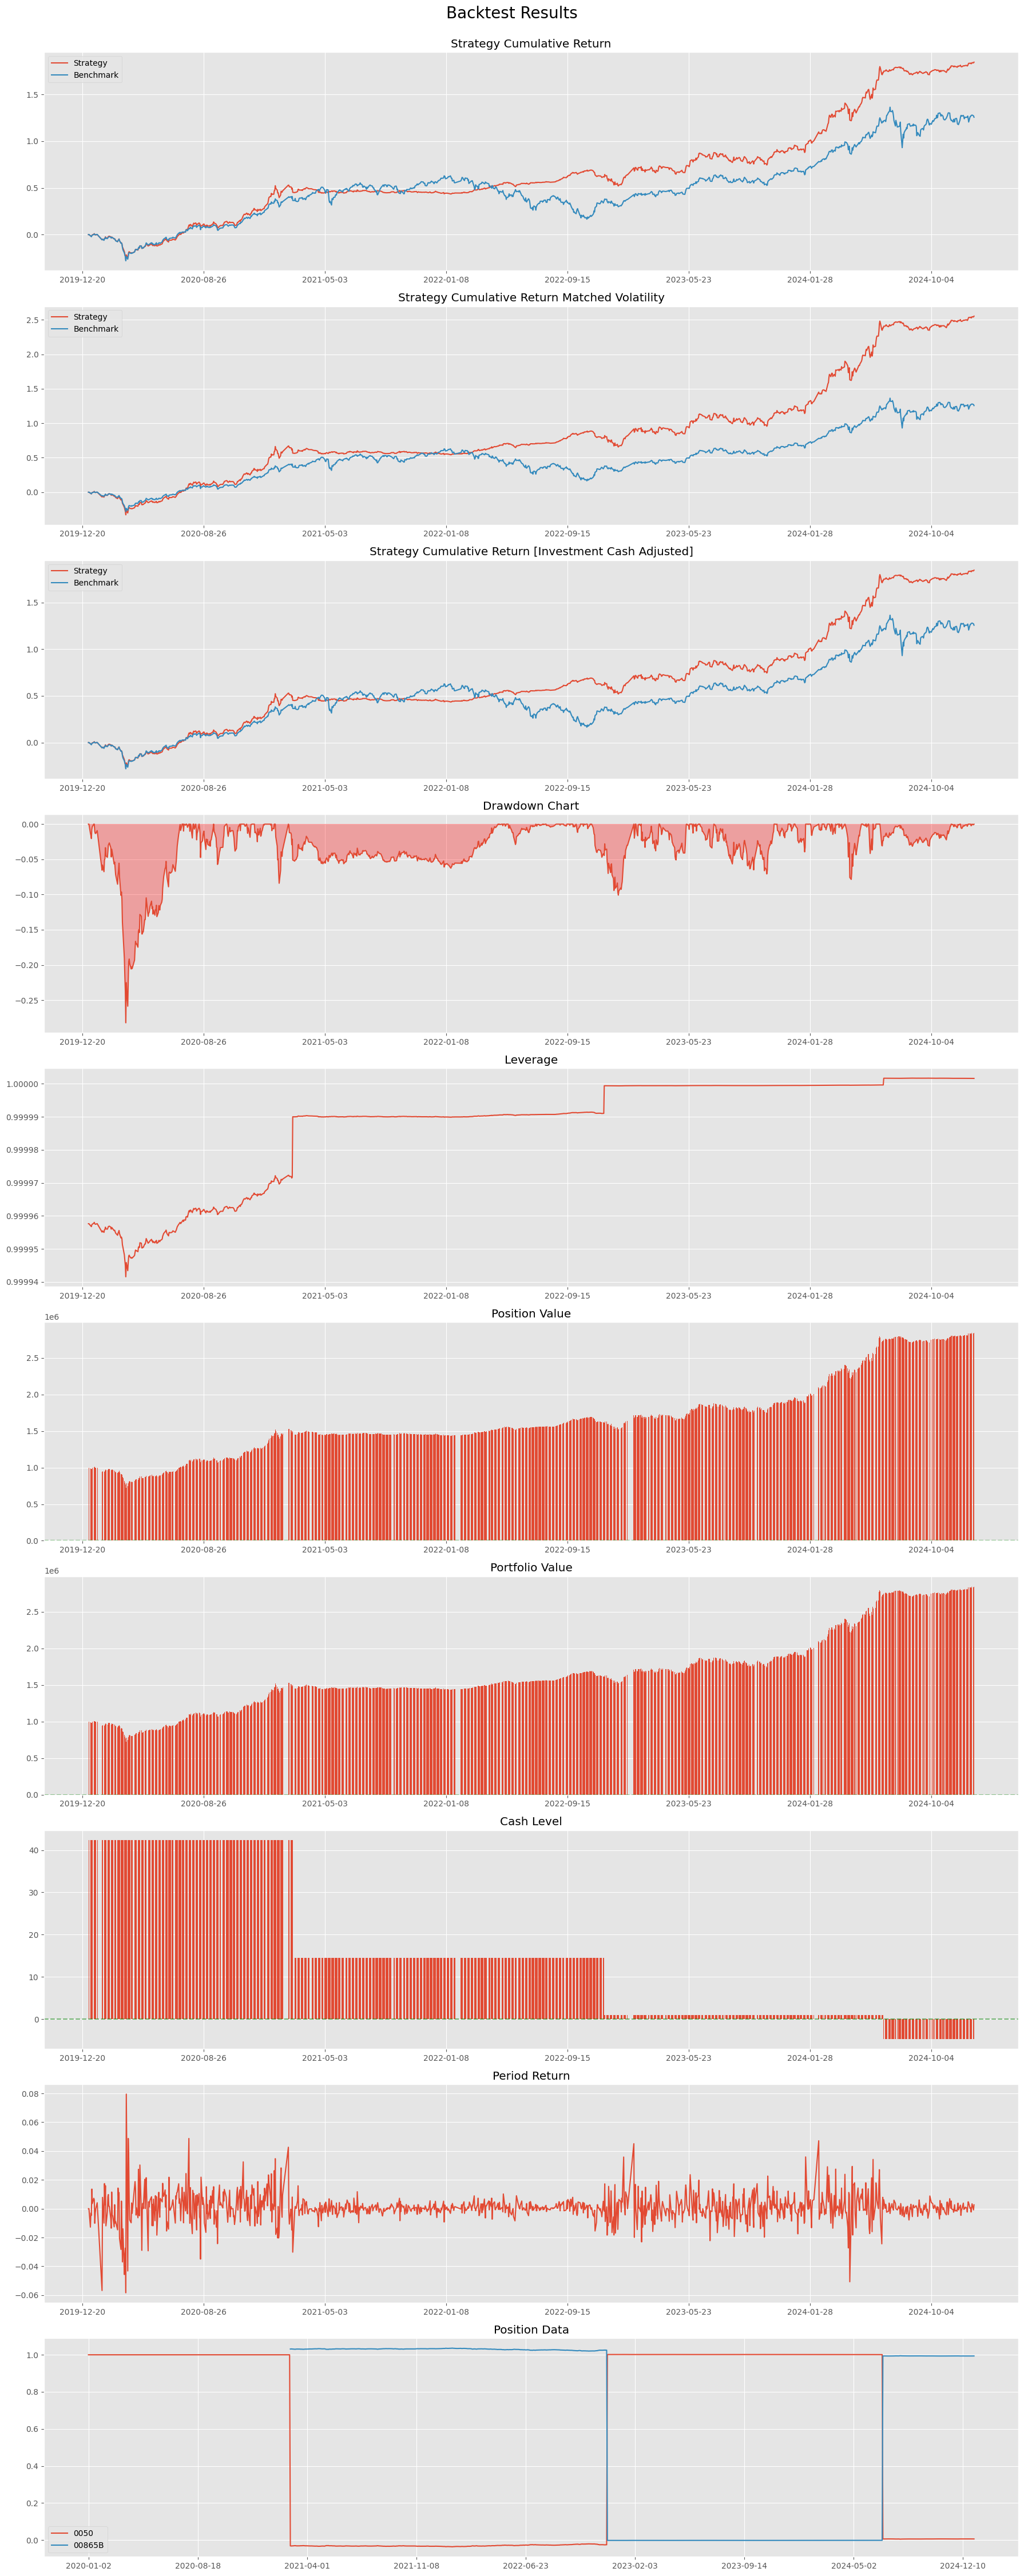

In [15]:
result.plot_performance()